In [1]:
from env import HighwayEnv, convert_highd_sample_to_gail_expert
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy

In [85]:
tracks = pd.read_csv(r"E:\Data\highd-dataset-v1.0\data\26_tracks.csv")

In [86]:
cars = tracks[tracks['width'] < 10]

In [87]:
trucks = tracks[~ (tracks['width'] < 10)]

In [94]:
cars.width.mean(), cars.width.std()

(4.882984629486892, 1.0121729613031003)

In [92]:
cars.height.mean(), cars.height.std()

(1.905026873778759, 0.17756152419257806)

In [96]:
trucks.width.mean(), trucks.width.std()

(15.708948857121014, 2.5270073585535773)

In [90]:
trucks.height.mean(), trucks.height.std()

(2.507716960137265, 0.0781221255525807)

In [428]:
lanes = tracks.laneId.unique()

num_cars = np.array([ cars[cars.laneId==l].id.nunique() for l in lanes])
num_trucks = np.array([ trucks[trucks.laneId==l].id.nunique() for l in lanes])

num_trucks / (num_cars + num_trucks)

array([0.        , 0.0877551 , 0.0042796 , 0.44507042, 0.40780142,
       0.05775578, 0.        ])

In [4]:
samples = tracks[(tracks.frame>=25*100)&(tracks.frame<=25*220)]
samples.to_csv("./data/26_sample_tracks.csv")

In [145]:
forward_mask = samples.groupby('id').xVelocity.transform('mean') > 0

In [146]:
forward = False

In [147]:
# average speed
df = samples[forward_mask] if forward else samples[~forward_mask]
df.groupby('laneId').xVelocity.mean()

# Compute vehicle center positions
df['center_x'] = df['x'] + 0.5 * df['width']
df['center_y'] = df['y'] + 0.5 * df['height']

# Get road start:
road_start = df['center_x'].min() - 10.0 if forward else df['center_x'].max() + 10.0 
road_end = df['center_x'].max() + 10.0 if forward else df['center_x'].min() - 10.0

road_start, road_end

C:\Users\Lucas\AppData\Local\Temp\ipykernel_52744\3569966275.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['center_x'] = df['x'] + 0.5 * df['width']
C:\Users\Lucas\AppData\Local\Temp\ipykernel_52744\3569966275.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['center_y'] = df['y'] + 0.5 * df['height']


(419.9, -18.165)

In [148]:
# first frame number of vehicles
firstFrameNumOfVehiclesPerLane = samples[samples.frame == samples.frame.min()].groupby('laneId')['id'].nunique()
firstFrameNumOfVehiclesPerLane

laneId
2    1
3    3
4    5
5    4
7    1
8    3
9    2
Name: id, dtype: int64

In [149]:
# Assume df is your DataFrame with columns: 'id', 'frame', 'laneId'
global_first_frame = df['frame'].min()

# Get the time length of dataset in seconds
lenT = (df['frame'].max() - df['frame'].min()) * (1/25)

# For each vehicle, get the first appearance (minimum frame)
first_appearance = df.sort_values('frame').groupby('id', as_index=False).first()

# Exclude vehicles that first appear in the global first frame
first_appearance_after = first_appearance[first_appearance['frame'] > global_first_frame]

# Create a mapping (or simply keep the columns 'id' and 'laneId')
first_appearance_laneId = first_appearance_after[['id', 'laneId']]

# Get the number of vehicles spawned on each lane
lane_vehicles_spawned = first_appearance_laneId.groupby('laneId').size()

# Get the number arrival ratio per lane, from left to right
lane_arrival_ratio = lane_vehicles_spawned / lenT

# Reverse if backward
lane_arrival_ratio = lane_arrival_ratio.values if forward else lane_arrival_ratio.values[::-1]

In [150]:
# last appearance 
last_appearance = df.sort_values('frame').groupby('id', as_index=False).last()

In [151]:
num_lanes = df.laneId.nunique()

In [160]:
arrival_lane_map = first_appearance[['id', 'laneId']].set_index('id')
departure_lane_map = last_appearance[['id', 'laneId']].set_index('id')

# Combine into a DataFrame.
arr_depart = pd.DataFrame({
    'arrival': arrival_lane_map.laneId,
    'departure': departure_lane_map.laneId
}, index=arrival_lane_map.index)

# Create a contingency table that counts vehicles for each (arrival, departure) pair.
table = pd.crosstab(arr_depart['arrival'], arr_depart['departure'])

# Determine all lanes that appear in either series.
all_lanes = sorted(set(arrival_lane_map.laneId.unique()) | set(departure_lane_map.laneId.unique()))
N = len(all_lanes)

# Reindex the table to ensure it has rows and columns for all lanes.
# This fills missing rows/columns with 0.
table = table.reindex(index=all_lanes, columns=all_lanes, fill_value=0)

# Normalize each row (arrival lane) so that they sum to 1.
M = table.div(table.sum(axis=1), axis=0).values

lcRatio = M if forward else M[::-1, ::-1]


In [164]:
lane_vel = df.groupby('laneId').xVelocity.mean().abs().values
lane_avg_vel = lane_vel if forward else lane_vel[::-1]
lane_avg_vel

array([40.65462569, 32.89017657, 25.07124386, 21.23384049])

In [1]:
from env import HighwayEnv, convert_highd_sample_to_gail_expert
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy

In [2]:
expert_data, df = convert_highd_sample_to_gail_expert(
        sample_csv=r"./data/26_sample_tracks.csv",
        meta_csv=r"E:\Data\highd-dataset-v1.0\data\26_recordingMeta.csv",
        forward=False,
        p_agent=0.5
    )

In [53]:
# Create the environment and set expert data.
env = HighwayEnv(dt=0.2, T=50, generation_mode=False, demo_mode=True)
# Uncomment and update the following line when expert_data is available:
env.set_expert_data(expert_data)

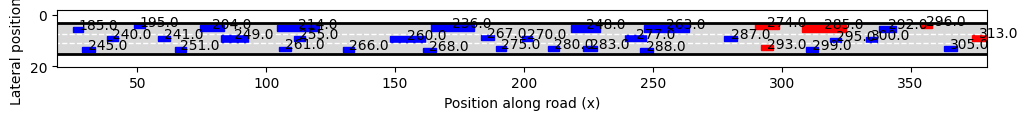

In [54]:
obs = env.reset()
env.render()

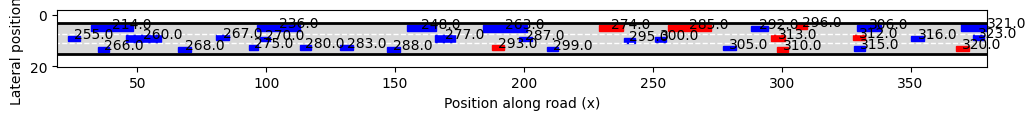

In [92]:
# Example: apply an action of [1.0, 0.5] for every vehicle slot.
actions = torch.full((env.N_max, 2), 5.0)
actions[:, 1] = 0
obs, reward, done, info = env.step(actions)
env.render()

In [93]:
actions

tensor([[-0.2700,  0.0000],
        [-0.4700,  0.0000],
        [-0.5000, -0.0000],
        [ 0.3100,  0.0000],
        [-0.1200,  0.0000],
        [-0.5800, -0.0500],
        [-0.3700,  0.0000],
        [-0.3500, -0.0500],
        [-0.2000,  0.0000],
        [ 5.0000,  0.0000],
        [ 5.0000,  0.0000],
        [ 0.1700,  0.0000],
        [ 0.5300,  0.0000],
        [ 5.0000,  0.0000],
        [-0.2200, -0.0500],
        [-0.2300,  0.0500],
        [ 0.6300, -0.2000],
        [-0.0400,  0.0000],
        [ 0.5300,  0.0500],
        [ 0.0000, -0.0500],
        [ 0.1400,  0.1000],
        [-0.3800,  0.0500],
        [ 0.1700,  0.1000],
        [-0.3400,  0.1000],
        [-0.5400,  0.0500],
        [-0.1900, -0.0500],
        [-0.3600,  0.0500],
        [-0.3000,  0.0000],
        [-0.1400,  0.1000],
        [ 0.1800,  0.0000],
        [-0.4100,  0.0500],
        [ 0.1400,  0.0500],
        [ 0.2000,  0.0500],
        [-0.4100,  0.0500],
        [-0.0400,  0.0500],
        [ 0.2400, -0

In [213]:
obs.keys()

dict_keys(['time_dependent', 'time_independent', 'lane_markers', 'boundary_lines', 'agent_mask'])

In [214]:
obs['time_dependent']

tensor([[[ 2.7355e+01,  8.9740e+00, -8.1080e+00, -2.0000e-02],
         [ 4.3939e+01,  8.7640e+00, -7.7940e+00, -3.0000e-02],
         [ 5.4317e+01,  8.4350e+00, -8.4400e+00,  2.0000e-02],
         ...,
         [        nan,         nan,         nan,         nan],
         [        nan,         nan,         nan,         nan],
         [        nan,         nan,         nan,         nan]],

        [[ 2.5732e+01,  8.9690e+00, -8.1220e+00, -3.0000e-02],
         [ 4.2386e+01,  8.7590e+00, -7.7380e+00, -2.0000e-02],
         [ 5.2650e+01,  8.4390e+00, -8.2300e+00,  2.0000e-02],
         ...,
         [        nan,         nan,         nan,         nan],
         [        nan,         nan,         nan,         nan],
         [        nan,         nan,         nan,         nan]],

        [[ 2.4104e+01,  8.9620e+00, -8.1500e+00, -4.0000e-02],
         [ 4.0843e+01,  8.7550e+00, -7.6880e+00, -2.0000e-02],
         [ 5.1022e+01,  8.4440e+00, -8.0520e+00,  3.0000e-02],
         ...,
         

In [24]:
obs['agent_mask']

tensor([1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [83]:
env.vehicle_ids

tensor([318, 319, 324, 326, 236, 320, 321, 317, 248, 325, 322, 327, 328,  -1,
        263,  -1,  -1,  -1,  -1, 274,  -1, 277, 280, 283, 285, 287, 288, 292,
        293, 295, 296, 299, 300, 305, 313, 314, 315, 316, 323,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1])

In [32]:
env.kinematics[:,2]

tensor([ 11.7499,  12.1659, -10.5580, -11.0820, -10.3660,  15.8836,      nan,
          4.2002,  -9.8780, -12.7780,      nan, -13.3620, -15.2540, -14.6580,
         -9.4540, -14.5680, -16.1660, -14.6980, -16.4200,  -9.6280, -14.8400,
        -10.8700, -15.0160, -14.5060,  -8.2480, -11.4640, -14.7560,  -7.5280,
        -15.7900, -12.1980,  -6.9200, -15.2960, -12.5520, -13.9080, -11.8800,
         10.5659,      nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan,      n

In [7]:
expert_data['lane_change_ratios']

array([[1.        , 0.        , 0.        ],
       [0.03508772, 0.92982456, 0.03508772],
       [0.02857143, 0.        , 0.97142857]])

In [8]:
env.lane_change_ratio

array([[1.        , 0.        , 0.        ],
       [0.03508772, 0.92982456, 0.03508772],
       [0.02857143, 0.        , 0.97142857]])

In [9]:
env.lanecenters

array([12.925,  9.125,  5.37 ])

In [92]:
env.kinematics[:,-2]

tensor([326., 315., 318., 321., 327., 316., 317., 319., 248., 320., 323., 324.,
        325.,  nan, 263.,  nan,  nan,  nan,  nan, 274.,  nan, 277.,  nan,  nan,
        285., 287., 288., 292.,  nan, 295., 296.,  nan, 300., 305., 313.,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan])

In [11]:
env.kinematics[:,7]

tensor([ 5.3700,  5.3700,  5.3700,  5.3700,  5.3700,  9.1250,  9.1250, 12.9250,
         5.3700,  9.1250, 12.9250,  9.1250,  9.1250, 12.9250,  5.3700, 12.9250,
         5.3700, 12.9250,  9.1250,  5.3700, 12.9250,  9.1250, 12.9250, 12.9250,
         5.3700,  9.1250, 12.9250,  5.3700, 12.9250,  9.1250,  5.3700, 12.9250,
         9.1250, 12.9250,  9.1250,     nan,     nan,     nan,     nan,     nan,
            nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
            nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
            nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
            nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
            nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
            nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
            nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
            nan,     nan,     nan,     n

In [65]:
env.history[-2,:,0]

tensor([125.0946,  35.5990,  67.3900,  58.3532, 430.7849,  24.4082,  63.0656,
        411.7750, 397.0049,      nan, 384.6922, 417.0928, 302.3247, 381.7200,
        337.4521, 336.8380, 290.8880, 229.5332, 244.5180, 176.7088, 233.3392,
        216.3092, 153.9234, 127.0608, 113.4750,  14.2870,      nan,      nan,
             nan,      nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan,      n

In [63]:
obs['time_dependent'][-1,:,0]

tensor([ 74.6688,   0.0000,  27.9132,  18.0028, 387.3597, 409.7956,  12.6110,
        375.2068, 338.1549, 369.2119, 343.4349, 341.1035, 265.6251, 314.1800,
        278.5575, 254.4210, 232.3878, 171.6048, 191.6114, 135.9614, 168.0821,
        150.6254, 113.8230,  97.8280,  64.8550,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.00

In [50]:
obs['time_independent']

tensor([[ 4.9500,  1.8200, 30.6000,  0.0000],
        [ 6.3700,  2.1200, 38.4200,  0.0000],
        [ 6.3700,  2.1200, 34.6900,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 4.8500,  2.0200, 38.4200,  1.0000],
        [ 4.1400,  1.7200, 34.6900,  0.0000],
        [ 5.2600,  1.9200, 30.6000,  0.0000],
        [ 4.6500,  1.7200, 34.6900,  1.0000],
        [ 4.3500,  1.7200, 38.4200,  1.0000],
        [ 4.5500,  1.8200, 30.6000,  0.0000],
        [ 4.7500,  1.9200, 34.6900,  0.0000],
        [ 4.7500,  1.9200, 30.6000,  1.0000],
        [ 4.6500,  1.8200, 38.4200,  0.0000],
        [ 7.4800,  2.1200, 30.6000,  0.0000],
        [ 4.1400,  1.6200, 30.6000,  1.0000],
        [ 7.7800,  2.5000, 34.6900,  1.0000],
        [ 5.1500,  1.8200, 30.6000,  0.0000],
        [14.5500,  2.5000, 38.4200,  0.0000],
        [ 5.1500,  1.9200, 34.6900,  0.0000],
        [ 5.3600,  1.9200, 38.4200,  1.0000],
        [ 4.6500,  1.8200, 30.6000,  1.0000],
        [ 4.9500,  1.8200, 34.6900

In [69]:
torch.sum(obs['time_dependent'][-1,:,0] > 0)

tensor(34)

In [103]:
veh_last_y = samples.sort_values('frame').groupby('id').last()['y']

In [3]:
lanecenters = np.concatenate((env.boundarylines[:1], env.lanemarkers, env.boundarylines[-1:]))
laneindices = np.argmin( np.abs(lanecenters - veh_last_y.values.reshape(-1,1)), axis=1)
last_lanecenters = lanecenters[laneindices]

veh_last_lanecenters = pd.Series(last_lanecenters, index=veh_last_y.index)

NameError: name 'env' is not defined

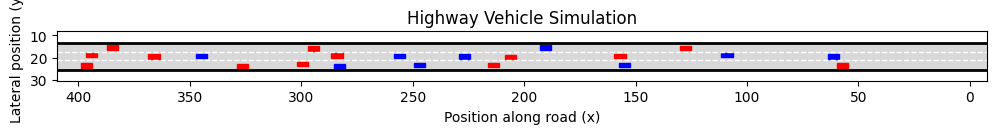

In [ ]:
obs = env.reset()
env.render()

In [74]:
env.kinematics

tensor([[ 8.9326e+01,  3.6647e+01,  1.4844e+01,  6.0000e-02,  4.8500e+00,
          1.9200e+00,  7.4000e+01],
        [ 7.9854e+01,  4.0483e+01,  1.4406e+01, -1.2000e-01,  5.4600e+00,
          2.0200e+00,  7.8000e+01],
        [ 6.6916e+01,  3.6189e+01,  1.3882e+01,  9.0000e-02,  4.6500e+00,
          1.8200e+00,  7.9000e+01],
        [ 4.3468e+02,  4.0416e+01,  1.9700e+01,  2.0000e-02,  4.6500e+00,
          1.7200e+00,  1.2000e+01],
        [ 3.1263e+01,  3.2525e+01,  1.6820e+01, -1.0000e-02,  4.6500e+00,
          1.8200e+00,  8.7000e+01],
        [ 3.1819e+01,  3.6474e+01,  1.6560e+01, -9.0000e-02,  8.3900e+00,
          2.5000e+00,  8.8000e+01],
        [ 3.8855e+02,  3.6688e+01,  1.8086e+01, -1.0000e-02,  4.6500e+00,
          1.8200e+00,  1.7000e+01],
        [ 1.4800e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 

In [75]:
obs['time_dependent'][-8:]

tensor([[[ 6.9045e+01,  3.6555e+01,  1.4158e+01,  8.0000e-02],
         [ 5.9440e+01,  4.0641e+01,  1.4764e+01, -8.0000e-02],
         [ 4.7645e+01,  3.6034e+01,  1.3634e+01,  1.2000e-01],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 7.1885e+01,  3.6570e+01,  1.4246e+01,  7.0000e-02],
         [ 6.2388e+01,  4.0623e+01,  1.4710e+01, -1.0000e-01],
         [ 5.0376e+01,  3.6058e+01,  1.3674e+01,  1.2000e-01],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 7.4743e+01,  3.6584e+01,  1.4336e+01,  7.0000e-02],
         [ 6.5325e+01,  4.0602e+01,  1.4658e+01, -1.1000e-01],
         [ 5.3115e+01,  3.6082e+01,  1.3712e+01,  1.2000e-01],
         ...,
         

In [629]:
env.history.shape

torch.Size([4, 100, 7])

In [679]:
hist = torch.full((50, 100, 4), float('nan'))

In [681]:
hist[-1] = env.kinematics[...,:4]

In [10]:
env.kinematics[:,4]

tensor([ 4.3500,  8.0800,  4.4500,  4.5500,  5.0500,  7.4800,  5.1500,  4.8500,
         5.0500,  5.2600,  4.8500, 19.1000,  4.4500,  4.6500,  5.3600,  4.8500,
         4.7500,  4.8500,  5.1500,  5.7600,  5.1500,  4.8500,  5.0500,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.00

In [ ]:
env.expert_data['boundarylines']

array([30.6 , 42.63])

In [77]:
env.expert_data['lanemarkers']

array([34.69, 38.42])

In [ ]:
np.concatenate([30,40][:1], [], [30,40][-1:])

In [25]:
env.kinematics[:,0].shape

torch.Size([100])

In [27]:
env.kinematics

tensor([[ 3.8200e+02,  4.0203e+01,  2.3550e+01, -2.0000e-03,  7.4800e+00,
          2.1200e+00],
        [ 4.2352e+02,  4.0635e+01,  2.4312e+01,  1.8400e-01,  8.0800e+00,
          2.5000e+00],
        [ 3.9612e+02,  4.0210e+01,  2.3590e+01,  2.0000e-02,  7.4800e+00,
          2.1200e+00],
        [ 4.3101e+02,  3.3031e+01,  2.8252e+01,  1.4800e-01,  4.5500e+00,
          1.8200e+00],
        [ 4.1083e+02,  3.2714e+01,  2.9602e+01, -3.6000e-02,  5.0500e+00,
          1.8200e+00],
        [ 3.2621e+02,  4.0042e+01,  2.3326e+01, -1.4800e-01,  7.4800e+00,
          2.1200e+00],
        [ 3.5678e+02,  3.6858e+01,  2.9660e+01,  9.0000e-02,  5.1500e+00,
          1.9200e+00],
        [ 3.7800e+02,  3.2904e+01,  3.3350e+01,  2.0000e-02,  4.8500e+00,
          1.8200e+00],
        [ 3.5050e+02,  3.2135e+01,  3.1816e+01, -2.4000e-02,  5.0500e+00,
          1.8200e+00],
        [ 3.1321e+02,  3.2582e+01,  3.0180e+01,  6.0000e-02,  5.2600e+00,
          1.9200e+00],
        [ 2.9913e+02,  3.6316e

In [31]:
env.exists

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])

In [30]:
env.kinematics[:,5]

tensor([2.1200, 2.5000, 2.1200, 1.8200, 1.8200, 2.1200, 1.9200, 1.8200, 1.8200,
        1.9200, 1.7200, 2.5000, 1.7200, 1.7200, 1.8200, 1.8200, 1.8200, 1.8200,
        1.7700, 1.9200, 1.8200, 1.8700, 1.9200, 2.1200, 2.5000, 1.9200, 1.7200,
        1.8200, 2.1200, 1.9200, 1.8200, 1.8200, 1.9200, 1.7200, 2.5000, 1.7200,
        1.7200, 1.8200, 1.8200, 1.8200, 1.8200, 1.7700, 1.9200, 1.8200, 1.8700,
        1.9200, 2.1200, 2.5000, 2.1200, 2.5000, 1.8200, 2.1200, 1.9200, 1.8200,
        1.8200, 1.9200, 1.7200, 2.5000, 1.7200, 1.7200, 1.8200, 1.8200, 1.8200,
        1.8200, 1.7700, 1.9200, 1.8200, 1.8700, 1.9200, 1.7200, 1.9200, 1.9200,
        1.8200, 2.1200, 1.9200, 1.8200, 1.8200, 1.9200, 1.7200, 2.5000, 1.7200,
        1.7200, 1.8200, 1.8200, 1.8200, 1.8200, 1.7700, 1.9200, 1.8200, 1.8700,
        1.9200, 1.8200, 1.7200, 1.9200, 1.8200, 1.8200, 2.1200, 1.9200, 1.8200,
        1.8200])

In [220]:
obs['time_independent'][:,0]

tensor([ 4.8500,  7.7800,  5.0500,  4.0400,  4.5500,  4.4500,  3.5400,  4.5500,
        16.9800, 19.2000,  4.5500,  5.4600,  5.1500,  5.0500,  5.0500,  5.0500,
         4.5500,  4.8500,  5.0500,  5.1500,  3.7400,  4.1400,  5.0500, 17.0800,
        16.9800,  4.1400,  4.9500,  3.9400,  3.5400,  4.2400,  5.3600,  5.1500,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.00

In [ ]:
# ===========================
# Example usage:
# ===========================
if __name__ == '__main__':
    # Assuming expert_data is provided by your version of convert_highd_sample_to_gail_expert()
    # For example:
    # expert_data = convert_highd_sample_to_gail_expert('/mnt/data/highd_sample.csv', '/mnt/data/25_tracksMeta.csv', forward=True, p_agent=0.5)
    
    # Create the environment and set expert data.
    env = HighwayEnv(p_agent=0.5)
    # Uncomment and update the following line when expert_data is available:
    # env.set_expert_data(expert_data)
    
    obs = env.reset()
    print("Initial observation:")
    for key, value in obs.items():
        if hasattr(value, 'shape'):
            print(f"{key}: {value.shape}")
        else:
            print(f"{key}: {value}")
    
    # Example: apply an action of [1.0, 0.5] for every vehicle slot.
    actions = torch.full((env.N_max, 2), 1.0)
    actions[:, 1] = 0.5
    obs, reward, done, info = env.step(actions)
    
    env.render()
    
    print("\nSample kinematics from the latest frame:")
    print(env.kinematics)

In [7]:
expert_data['lanemarkers']

array([34.69, 38.42])

In [8]:
expert_data['boundarylines']

array([30.85, 42.38])

In [8]:
meta = pd.read_csv('D:/Productivity/Projects/High-D/highd-dataset-v1.0/data/25_recordingMeta.csv')

In [15]:
marks = meta['lowerLaneMarkings'].iloc[0].split(';')
marks = np.array(marks, dtype=float)
marks

array([30.85, 34.69, 38.42, 42.38])

In [17]:
marks[[0,-1]]

array([30.85, 42.38])

In [19]:
marks[:2][1:-1]

array([], dtype=float64)

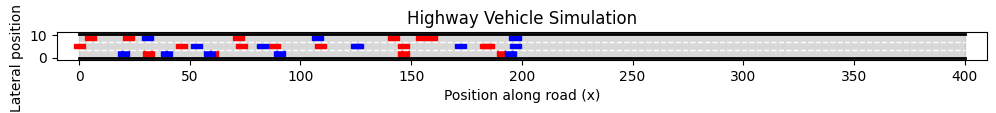

Initial observation:
time_dependent torch.Size([4, 100, 4])
time_independent torch.Size([100, 3])
additional torch.Size([5])
mask torch.Size([100])
agent_mask torch.Size([100])


In [6]:
env = HighwayEnv(road_end=400)
obs = env.reset()
env.render()
print("Initial observation:")
for key, value in obs.items():
    print(key, value.shape)

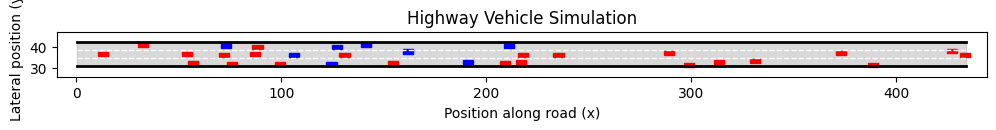

In [164]:
actions = torch.full((env.N_max, 2), 0.2)
actions[:, 1] = 0
obs, reward, done, info = env.step(actions)
env.render()

In [5]:
tracks = pd.read_csv(r"D:\Productivity\Projects\High-D\highd-dataset-v1.0\data\25_tracks.csv")

In [295]:
veh = tracks[tracks.id == 158]

In [296]:
x0 = veh.x.iloc[0]
y0 = veh.y.iloc[0]
vx0 = veh.xVelocity.iloc[0]
vy0 = veh.yVelocity.iloc[0]

x = x0
y = y0
vx = vx0
vy = vy0

X = [x0]
Y = [y0]
F = [veh.frame.iloc[0]]

In [297]:
_yAcceleration = veh.yVelocity.diff()[1:] * 25
_yAcceleration = np.append(_yAcceleration.values, [0])

In [298]:
step = 1
dt = step / 25
for t in range(0, len(veh), step):
    ax = veh.xAcceleration.values[t]
    ay = (veh.yVelocity.iloc[t+step] - veh.yVelocity.iloc[t])/dt if t+step < len(veh) else 0
    print (ay)
    f = veh.frame.values[t]
    x += vx*dt + 0.5*ax*dt**2
    y += vy*dt + 0.5*ay*dt**2
    vx += ax*dt
    vy +=  ay*dt

    X.append(x)
    Y.append(y)
    F.append(f)

-0.25
0.0
0.0
0.0
-0.25
0.0
0.0
0.0
-0.24999999999999994
0.0
0.0
0.0
0.0
-0.25000000000000006
0.0
0.0
0.0
-0.25000000000000006
0.0
0.0
0.0
0.0
-0.24999999999999986
0.0
0.0
0.0
0.0
0.0
-0.2500000000000002
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.2500000000000002
0.0
0.0
0.0
0.0
0.0
0.24999999999999986
0.0
0.0
0.0
0.25000000000000006
0.0
0.0
0.0
0.25000000000000006
0.0
0.0
0.0
0.24999999999999994
0.0
0.0
0.25
0.0
0.0
0.25
0.0
0.0
0.0
0.25
0.0
0.0
0.25
0.0
0.0
0.0
0.24999999999999994
0.0
0.0
0.25000000000000006
0.0
0.0
0.0
0.25000000000000006
0.0
0.0
0.0
0.24999999999999986
0.0
0.0
0.0
0.2500000000000002
0.0
0.0
0.0
0.0
0.0
0.0
0.24999999999999986
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.24999999999999986
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.2500000000000002
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.24999999999999986
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.24999999999999986
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.2500000000000002
0.0
0.0
0.

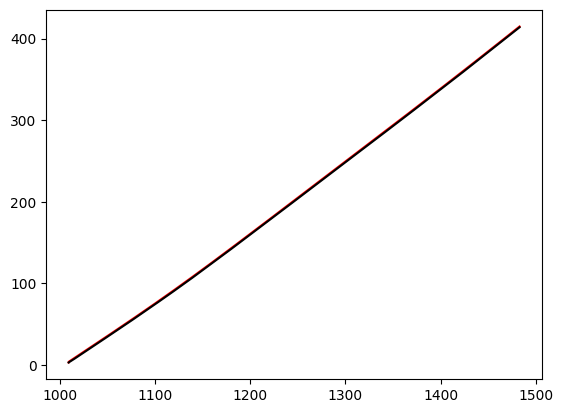

In [299]:
plt.plot(F, X, color='red')
plt.plot(veh.frame, veh.x, color='black')

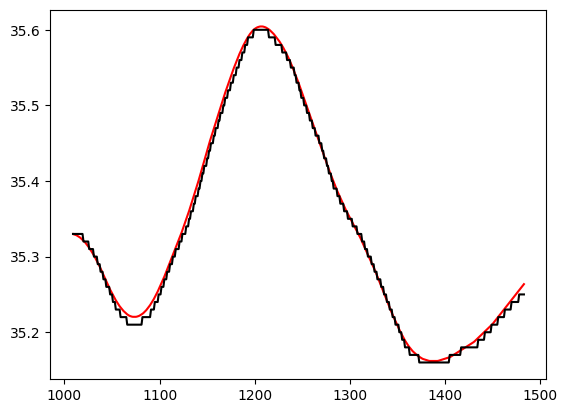

In [300]:
plt.plot(F, Y, color='red')
plt.plot(veh.frame, veh.y, color='black')

In [244]:
veh.xVelocity

17150   -9.62
17151   -9.62
17152   -9.63
17153   -9.64
17154   -9.64
         ... 
17920   -9.45
17921   -9.44
17922   -9.43
17923   -9.41
17924   -9.40
Name: xVelocity, Length: 775, dtype: float64

In [303]:
def rectify_y_acceleration(df, dt=1/25):
    """
    Reads a sample CSV file (e.g. highd_sample.csv) that contains vehicle data with columns including:
      - 'frame', 'id', 'y'
      - (and a column 'yAcceleration' that may be inaccurate)
    
    This function computes a rectified yAcceleration for each vehicle using central differences:
    
        a_y(t) = (y(t+dt) - 2*y(t) + y(t-dt)) / (dt**2)
    
    For the first and last frames for each vehicle, forward and backward differences are used respectively.
    
    The resulting acceleration replaces the original 'yAcceleration' column and the updated data is saved to output_csv.
    
    Parameters:
        input_csv (str): Path to the input CSV file.
        output_csv (str): Path to write the rectified CSV.
        dt (float): Time interval between frames (default is 1/25 seconds).
    """
    
    # Function to compute rectified yAcceleration for one vehicle (grouped by 'id')
    def compute_yAcc(group):
        group = group.sort_values('frame').copy()
        y = group['y'].values
        n = len(y)
        new_a = np.zeros(n)
        # Use central differences for interior points.
        if n >= 3:
            new_a[1:-1] = (y[2:] - 2 * y[1:-1] + y[:-2]) / (dt ** 2)
        # For the first frame, use forward difference:
        if n >= 2:
            new_a[0] = (y[1] - y[0]) / dt  # approximate derivative (velocity), not acceleration,
            # but as a fallback we use it as an approximation for a_y at t=0.
            # Alternatively, you could use: new_a[0] = (y[2] - 2*y[1] + y[0])/(dt**2) if n>=3.
            new_a[-1] = (y[-1] - y[-2]) / dt  # backward difference for last frame.
        elif n == 1:
            new_a[0] = 0  # Single sample: assume zero acceleration.
        group['yAcceleration_rectified'] = new_a
        return group

    # Apply the computation for each vehicle.
    df = df.groupby('id').apply(compute_yAcc)
    # Optionally, replace the original 'yAcceleration' with the rectified one.
    df['yAcceleration'] = df['yAcceleration_rectified']
    df.drop(columns=['yAcceleration_rectified'], inplace=True)
    
    # Save the rectified data to the output CSV.
    
    return df

In [6]:
sample = tracks[(tracks.frame>=(25*540))&(tracks.frame<(25*600))]

In [36]:
df.id.unique()

array([1266, 1267, 1269, 1270, 1273, 1274, 1275, 1277, 1278, 1280, 1282,
       1283, 1284, 1285, 1287, 1288, 1290, 1291, 1292, 1294, 1296, 1298,
       1302, 1304, 1306, 1307, 1310, 1311, 1313, 1314, 1315, 1318, 1319,
       1321, 1325, 1327, 1328, 1329, 1331, 1333, 1334, 1335, 1337, 1338,
       1340, 1341, 1345, 1346, 1348, 1349, 1350, 1351, 1352, 1354, 1356,
       1358, 1360, 1361, 1362, 1364, 1365, 1368, 1369, 1372, 1373, 1374,
       1375, 1377, 1379, 1381, 1382, 1383, 1385, 1387, 1388, 1389, 1391,
       1392, 1394, 1395, 1396, 1397, 1400, 1401, 1403, 1405, 1407, 1408,
       1410, 1411, 1412, 1415, 1416, 1418, 1419, 1421, 1422, 1426, 1427,
       1428, 1431, 1433, 1435, 1436, 1437, 1439, 1440, 1441, 1443, 1445,
       1449, 1450, 1453])

In [32]:
veh = sample[sample.id==1417]

In [37]:
_veh = df[df.id==1381]

In [38]:
_y = _veh.y.iloc[0]
_vy = _veh.yVelocity.iloc[0]
_Y = []
_F = []
skip = 5
dt = 1/25 * skip
for t in range(0, len(_veh), skip):
    _y += _vy*dt + 0.5*_veh.yAcceleration.values[t] * dt**2
    _vy += _veh.yAcceleration.values[t] * dt
    _Y.append(_y)
    _F.append(_veh.frame.iloc[t])


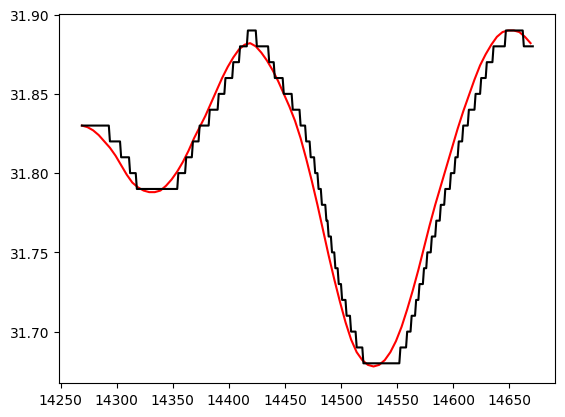

In [39]:
plt.plot(_F, _Y, color='red')
plt.plot(_veh.frame, _veh.y, color='black')

In [305]:
rectify_y_acceleration(sample, dt=1/25)

C:\Users\APT1807\AppData\Local\Temp\ipykernel_65592\4128286346.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('id').apply(compute_yAcc)


frame    id      x      y  width  height  xVelocity  yVelocity  \
id                                                                             
1129 809664   13500  1129  18.84  14.38  16.88    2.50      -3.59       0.07   
     809665   13501  1129  18.69  14.39  16.88    2.50      -3.56       0.07   
     809666   13502  1129  18.55  14.39  16.88    2.50      -3.54       0.07   
     809667   13503  1129  18.39  14.39  16.88    2.50      -3.51       0.07   
     809668   13504  1129  18.25  14.40  16.88    2.50      -3.49       0.07   
...             ...   ...    ...    ...    ...     ...        ...        ...   
1453 1029530  14995  1453   8.91  31.17   4.75    1.72      26.17      -0.00   
     1029531  14996  1453   9.84  31.16   4.75    1.72      26.18      -0.00   
     1029532  14997  1453  10.77  31.16   4.75    1.72      26.18      -0.01   
     1029533  14998  1453  11.75  31.16   4.75    1.72      26.19      -0.01   
     1029534  14999  1453  12.76  31.16   4.75    1.72      26.20      -0.01   

              xAcceleration  yAcceleration  ...  precedingXVelocity  \
id                                          ...                       
1129 809664            0.60           0.25  ...                0.00   
     809665            0.62          -6.25  ...                0.00   
     809666            0.64           0.00  ...                0.00   
     809667            0.67           6.25  ...                0.00   
     809668            0.69          -6.25  ...                0.00   
...                     ...            ...  ...                 ...   
1453 1029530           0.15          -0.25  ...               25.96   
     1029531           0.16           6.25  ...               25.96   
     1029532           0.16           0.00  ...               25.97   
     1029533           0.17           0.00  ...               25.97   
     1029534           0.17           0.00  ...               25.98   

              precedingId  followingId  leftPrecedingId  leftAlongsideId  \
id                                                                         
1129 809664             0         1264                0             1217   
     809665             0         1264                0             1217   
     809666             0         1264                0             1217   
     809667             0         1264                0             1217   
     809668             0         1264                0             1217   
...                   ...          ...              ...              ...   
1453 1029530         1445            0                0                0   
     1029531         1445            0                0                0   
     1029532         1445            0                0                0   
     1029533         1445            0                0                0   
     1029534         1445            0                0                0   

              leftFollowingId  rightPrecedingId  rightAlongsideId  \
id                                                                  
1129 809664              1221                 0                 0   
     809665              1221                 0                 0   
     809666              1221                 0                 0   
     809667              1221                 0                 0   
     809668              1221                 0                 0   
...                       ...               ...               ...   
1453 1029530                0              1450                 0   
     1029531                0              1450                 0   
     1029532                0              1450                 0   
     1029533                0              1450                 0   
     1029534                0              1450                 0   

              rightFollowingId  laneId  
id                                      
1129 809664                  0       2  
     809665                  0       2 

In [4]:
sample = tracks[(tracks.frame>=(25*540))&(tracks.frame<(25*600))]
sample.to_csv("./data/highd_sample.csv")

NameError: name 'tracks' is not defined

In [19]:
forward_mask = sample.groupby('id').xVelocity.transform('mean') > 0

In [20]:
forward_mask.shape, sample.shape

((98495,), (98495, 25))

In [8]:
env.exists

tensor([ True, False,  True, False, False, False, False,  True, False, False,
         True, False, False,  True, False,  True, False,  True, False, False,
        False, False, False, False, False,  True, False,  True, False,  True,
        False, False, False, False, False, False, False, False, False, False,
        False,  True,  True, False, False,  True, False,  True, False,  True,
         True,  True, False,  True,  True, False, False,  True, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False,  True, False, False, False, False,
        False, False,  True, False, False, False, False, False, False,  True,
         True, False, False, False,  True, False, False, False, False,  True])

In [9]:
env.agent_mask

tensor([ True, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False])

In [1]:
from env import MultiAgentHighwayEnv  # adjust if in same file
import torch

In [57]:
# Initialize environment
env = MultiAgentHighwayEnv(dt=0.2)


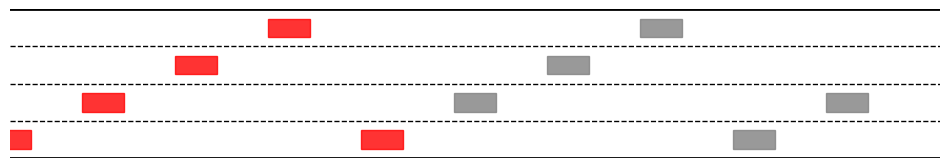

In [58]:
env = MultiAgentHighwayEnv()
obs, info = env.reset()
env.render()

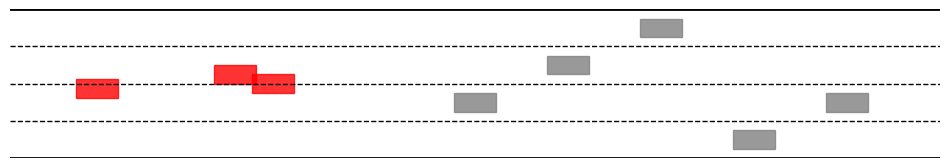

In [102]:
actions = [torch.randn(env.T_prime, 2) for _ in env.action_buffers]
obs, rewards, dones, infos = env.step(actions)
env.render()



In [26]:
actions

[tensor([[ 0.4732,  0.9310],
         [ 0.6433,  0.1576],
         [ 1.4890, -0.1784],
         [ 0.1631, -1.0198],
         [-0.8230, -0.1053]]),
 tensor([[-1.0888, -1.4147],
         [ 1.2990, -0.3433],
         [ 1.7159,  0.5807],
         [-1.6898, -0.4576],
         [-0.1072, -0.3186]]),
 tensor([[ 0.1749,  0.1477],
         [-0.1293,  0.0134],
         [ 1.0926,  0.6587],
         [-0.2755,  0.5467],
         [-0.0320, -0.8149]]),
 tensor([[-0.8804,  0.9187],
         [ 1.0990, -0.0484],
         [ 0.6742, -0.4954],
         [-0.3304,  0.8232],
         [-1.6462,  0.8743]]),
 tensor([[-1.1382, -0.4010],
         [ 1.8606, -1.4020],
         [-1.0849,  0.5183],
         [-0.6433,  0.6027],
         [-1.3437, -0.6037]])]